In [ ]:
# double check:
# 1. make sure that the update works for the score tensor, the values in the tensor, etc
# 2. make sure the new win loss from the search tree is accurately represented as well:

# today end of day:
# 1. Test a run of the full searcher. Check you are happy with where the time is being spent and that
#     it all adds up fine
# 2. Start a full searcher running. If we get 1000 games each time, and we can sync it to run continually
#     by syncing the network every 1000 games, that should work well i think. 
# 3. Figure out how to blend the games together as it plays. Do we want to weight games closer to 
#     the end a little more heavily?
# 4. Check the actual validation losses under CE and see when it does worst there.

In [1]:
import random
import datetime
import os
from pathlib import Path

import numpy as np
import copy
from importlib import reload
import torch
import int_to_board
import pickle

reload(int_to_board)

import game
reload(game)

import plotting
reload(plotting)

import mcts.mcts
reload(mcts.mcts)

import mcts.networks
reload(mcts.networks)

import mcts.agent
reload(mcts.agent)

import augmentor
reload(augmentor)

from game import Patterns
from plotting import PatternPlotter

from mcts.mcts import Tree, Node
from mcts.networks import PatternsNet
from mcts.agent import Agent

from augmentor import StateAugmentor

# rseed = 12387623
# random.seed(rseed)
# torch.manual_seed(rseed)
# np.random.seed(rseed)

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
my_network = PatternsNet(
    in_channels=47,
    # EDIT: new shape of the channels
    # [board_tensor, order_tensor, bowl_tensor, placing_tensor, score_tensor, token_value_tensor]
    # 47 for the number of state planes: 
    # 18 for the board (6 colors per passive, p1, p2)
    # 12 for the order (6 per player, float layers)
    # 12 for bowl tokens (6 per player, indicating current token)
    # 1 for is no more placing
    # 2 for score tensor (1 per player, float layers)
    # 2 for token value tensor (1 per player, float for the relative score of the token in the bowl)
    out_channels=128,  
    # 49076716 params if 128 out channels used
    # 12295468 params if 64 is used instead
)

# sum(p.numel() for p in my_network.parameters() if p.requires_grad)


In [ ]:
# Load up previous best networks to help play the games (lets see how it does!).
# in time, have best of a generation playing against each other!
network_path = os.path.join(Path.cwd(), 'saved_networks', 'v3', '2025_07_10_03_58.pt')
my_network = PatternsNet(in_channels=47, out_channels=128)
my_network.load_state_dict(torch.load(network_path, weights_only=True))


In [ ]:
# Run a random game first:
my_game = Patterns()
num_moves = 40

for _ in range(num_moves):
    actions = my_game.get_actions()
    action = random.choice(actions)
    is_terminal, result = my_game.step(action)
    
    if is_terminal:
        break

    pplotter = PatternPlotter(my_game)
    pplotter.plot()


pplotter = PatternPlotter(my_game)
pplotter.plot()

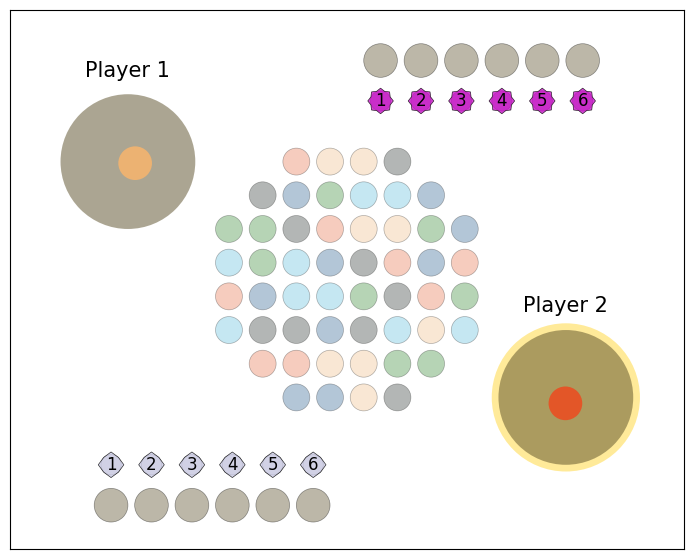

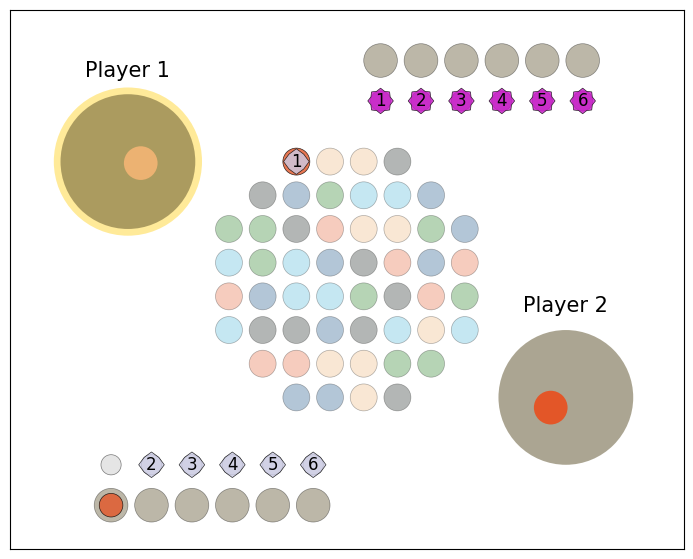

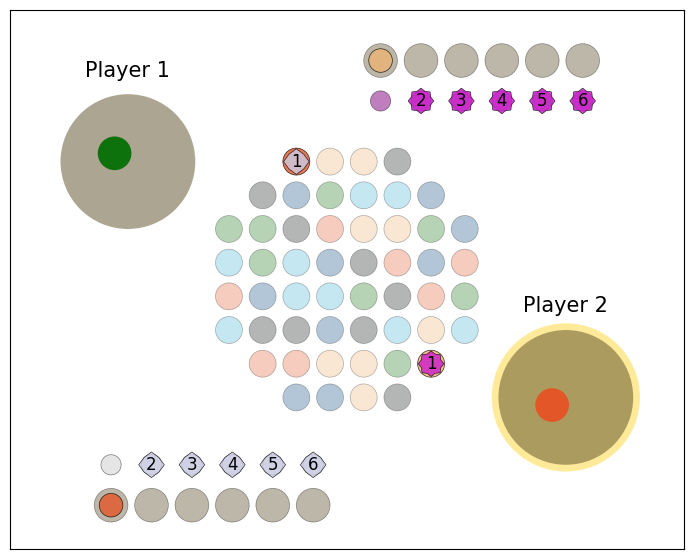

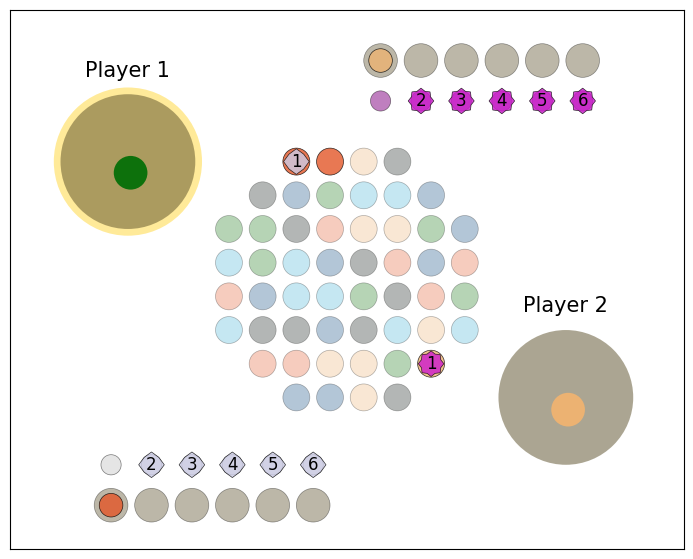

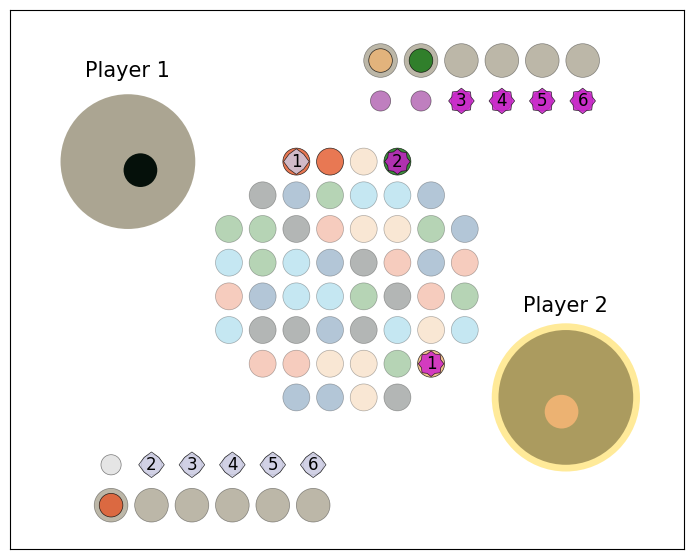

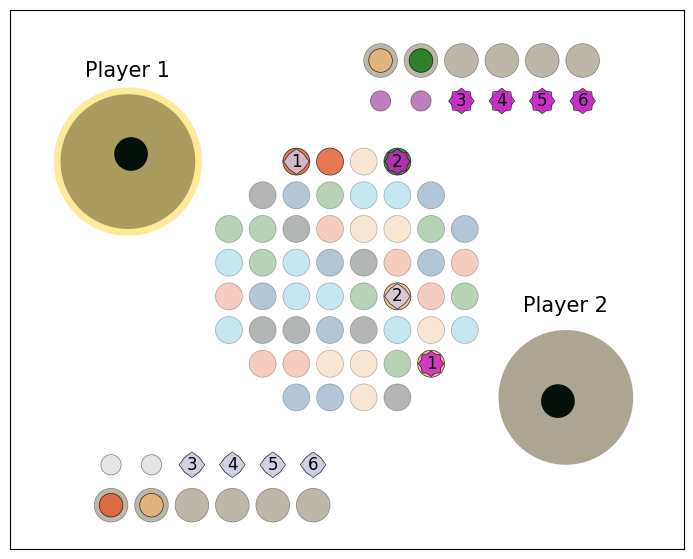

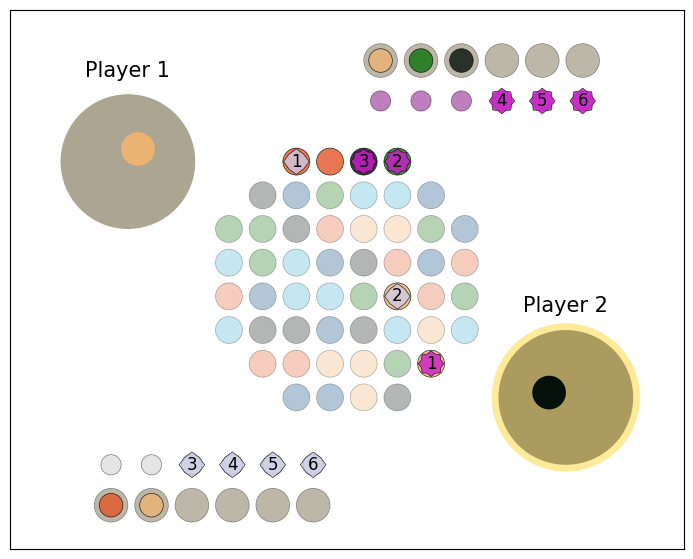

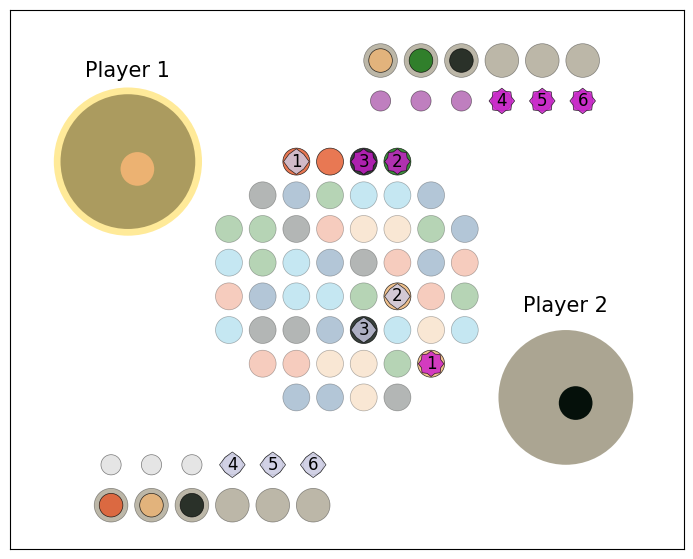

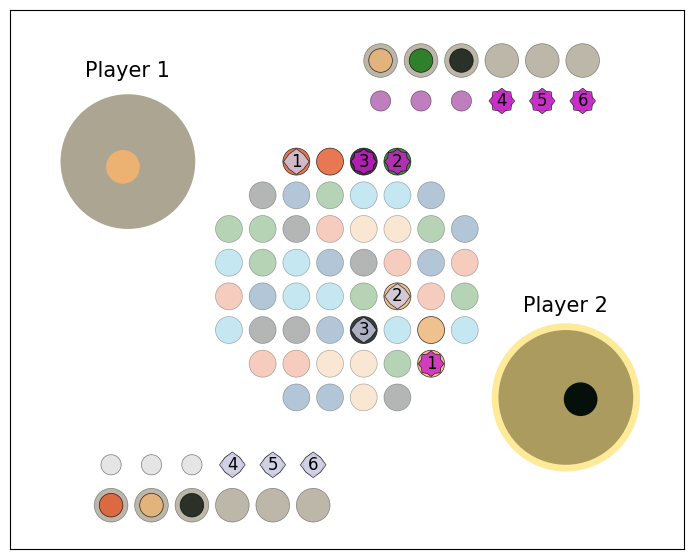

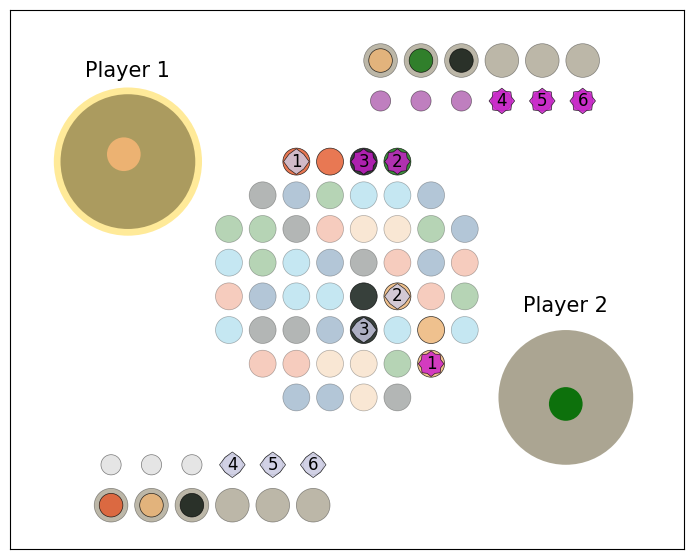

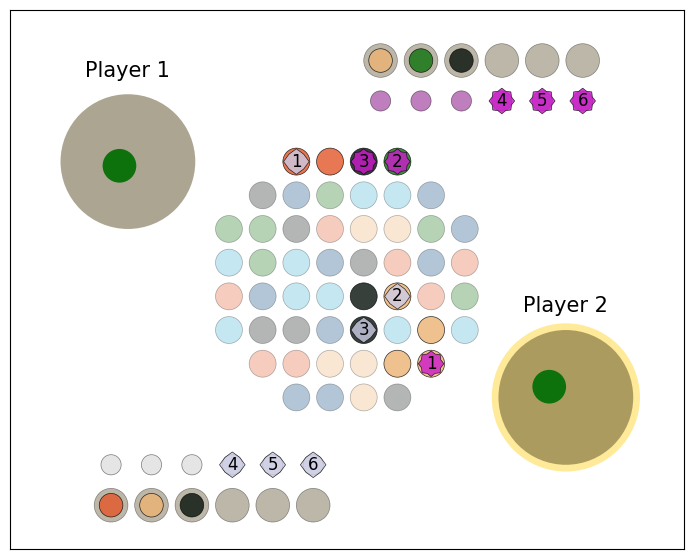

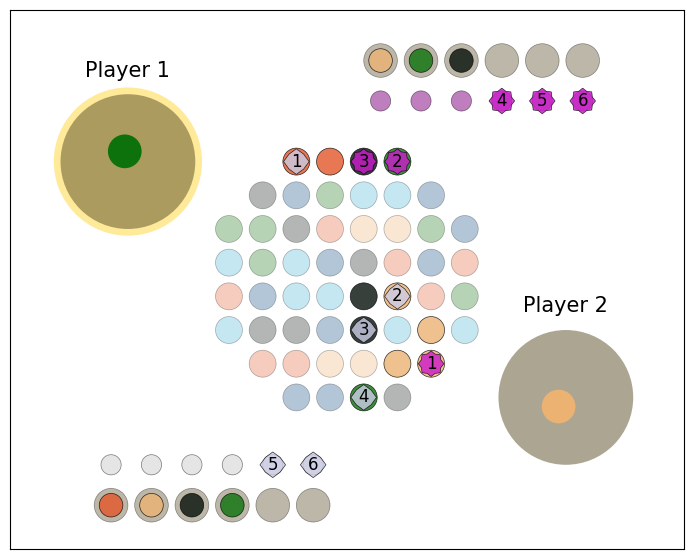

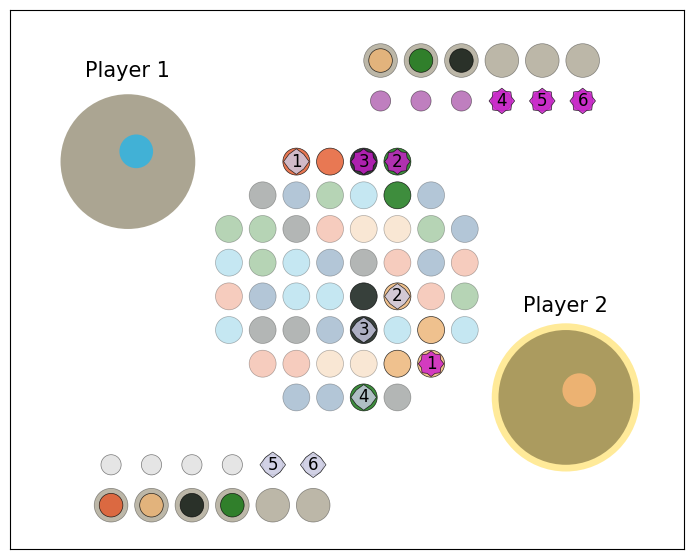

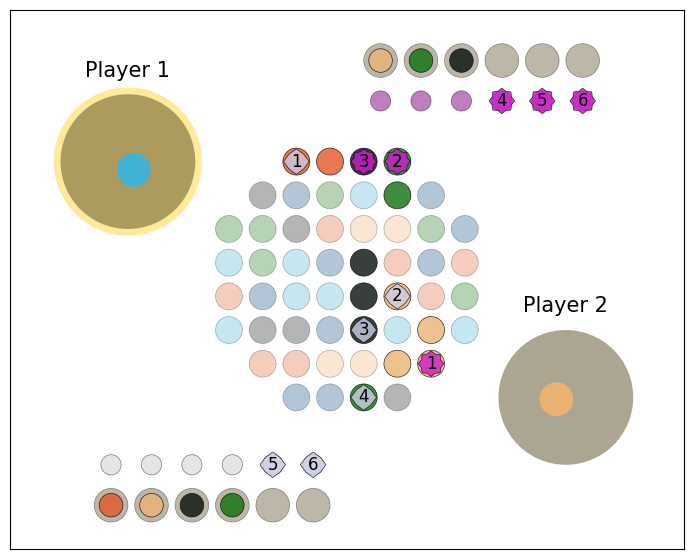

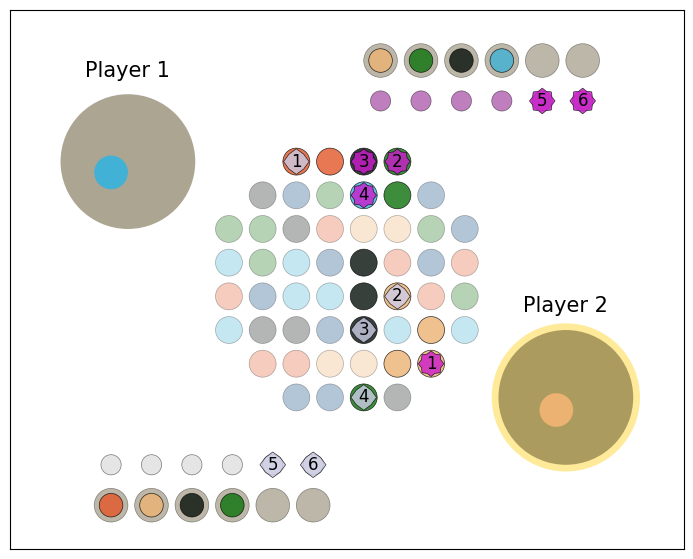

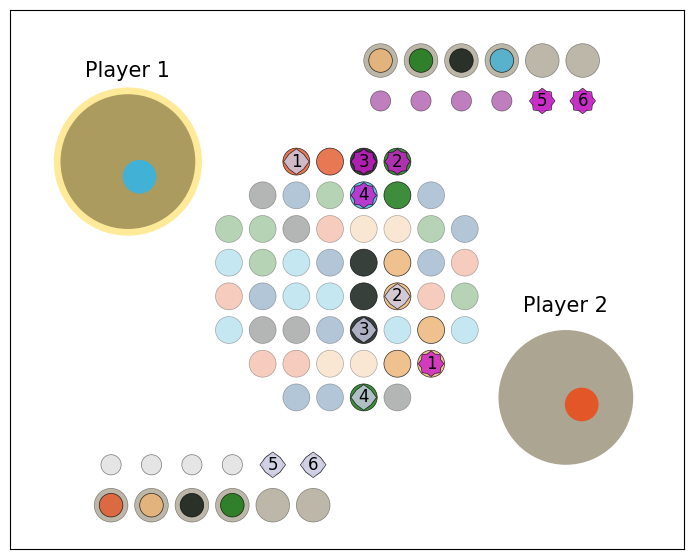

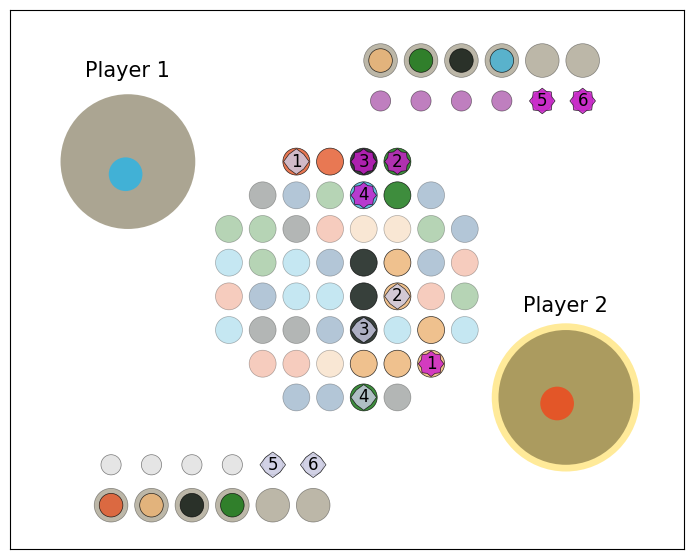

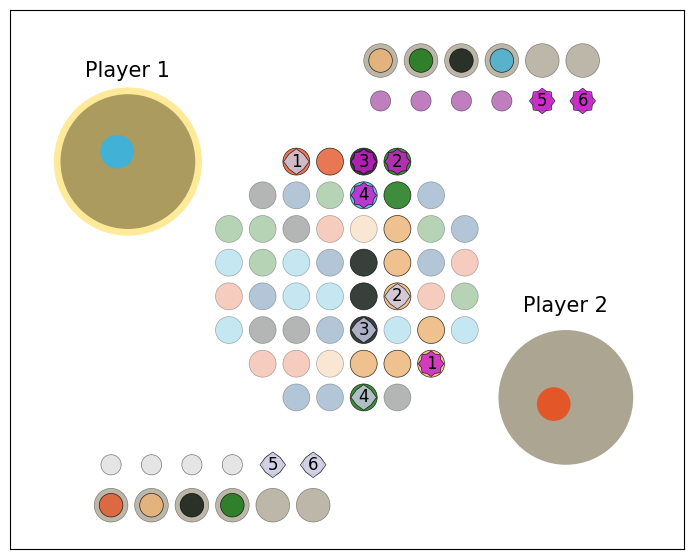

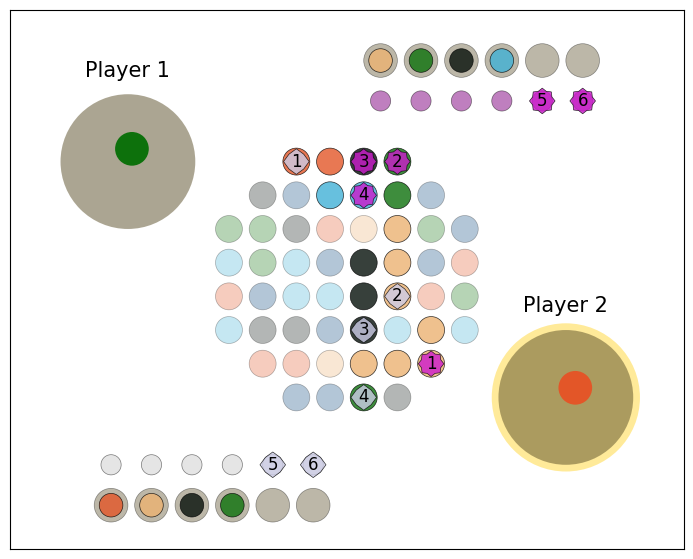

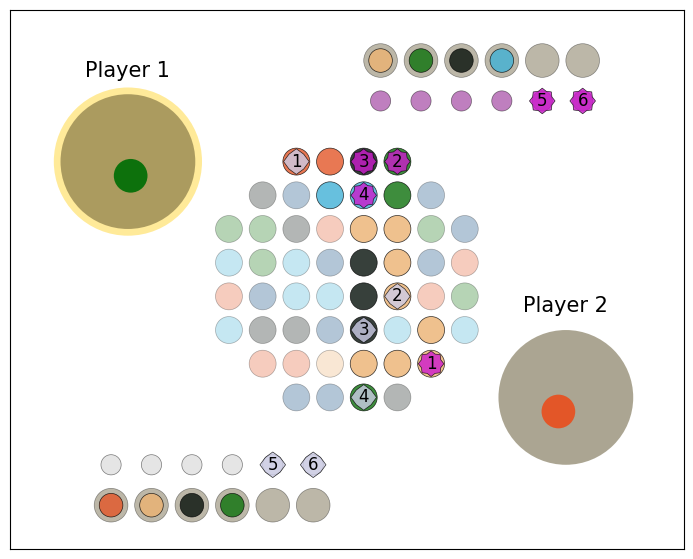

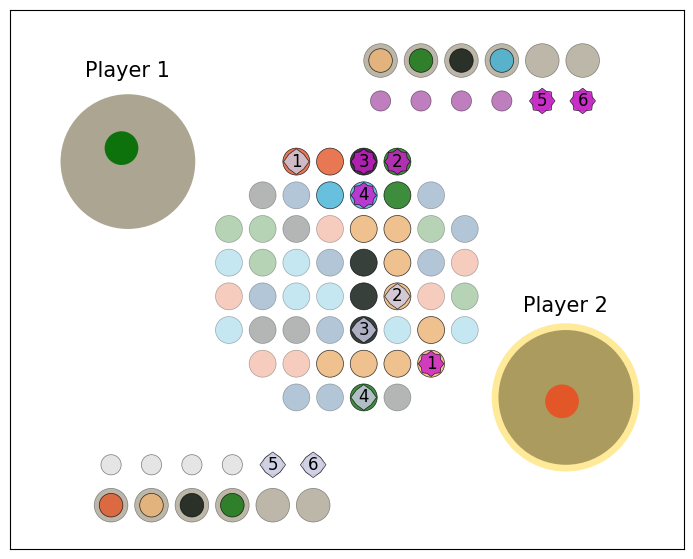

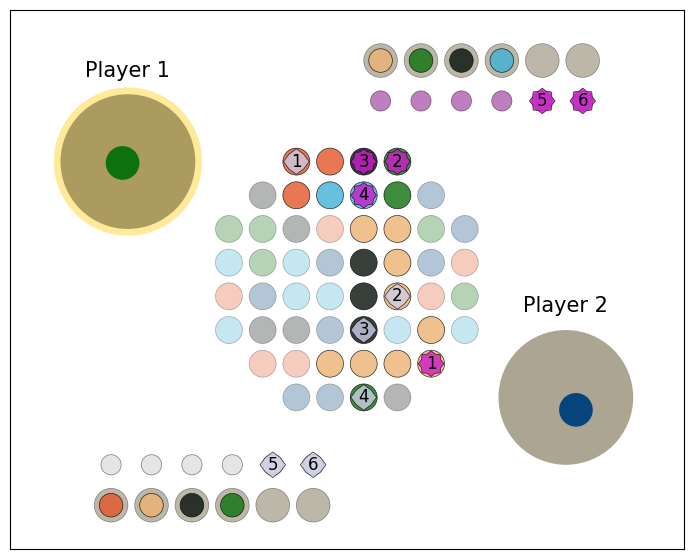

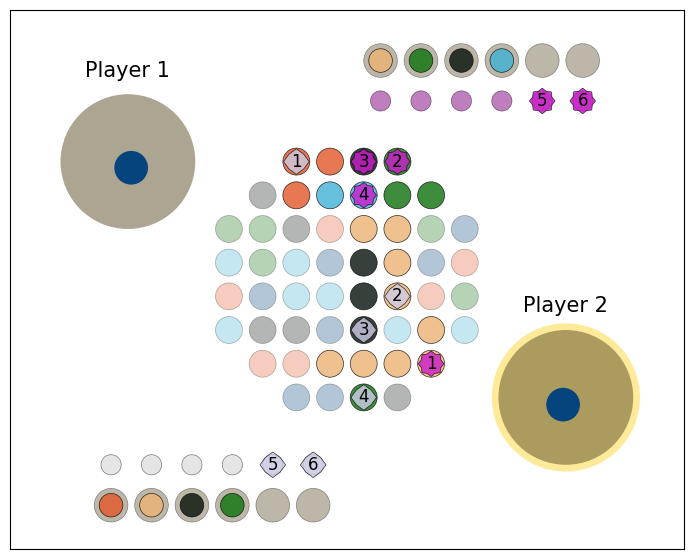

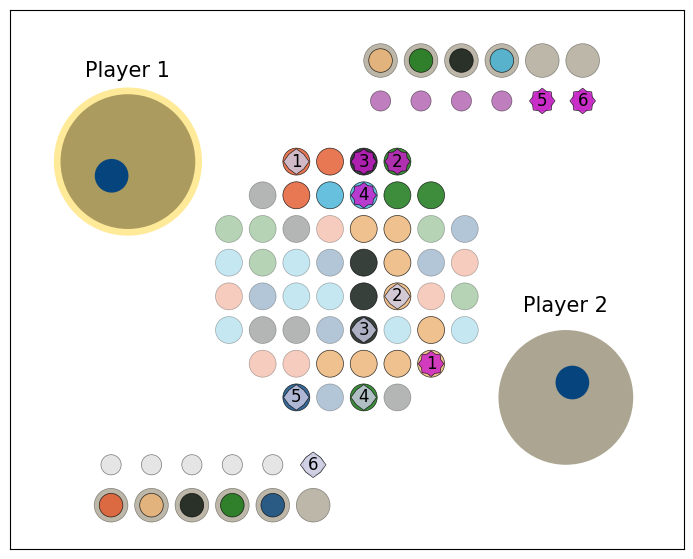

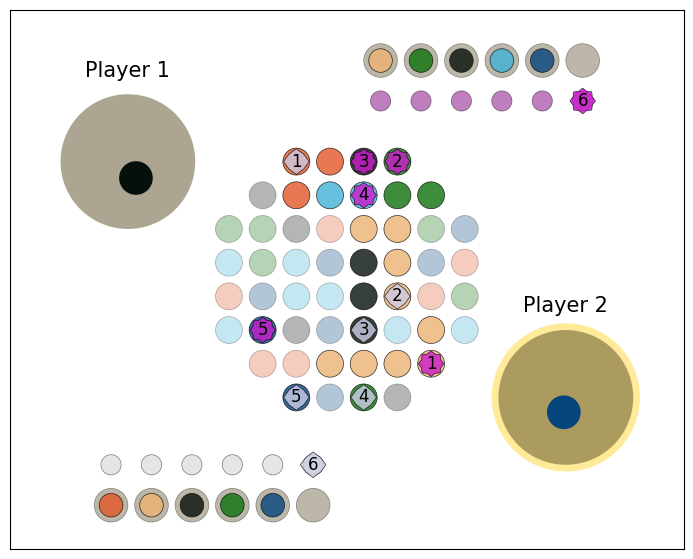

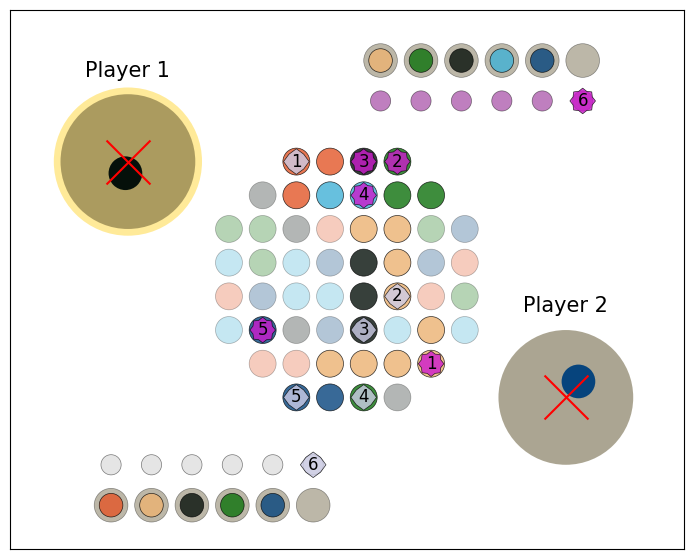

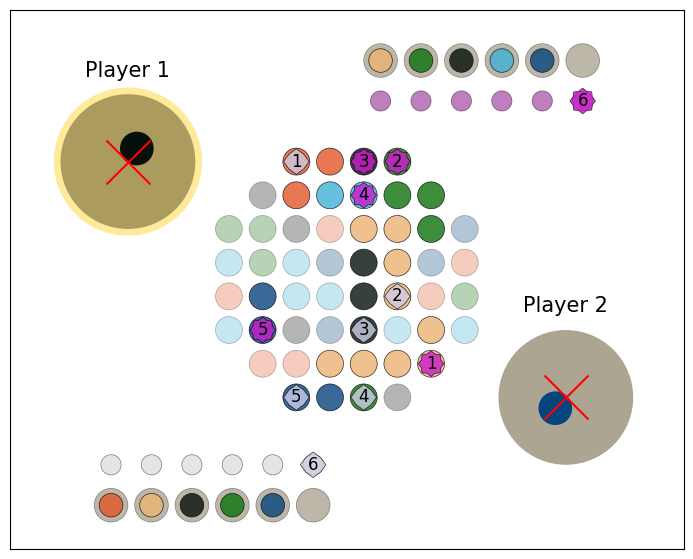

In [3]:
# Run a random game first:
my_game = Patterns()
num_moves = 40

for _ in range(num_moves):
    actions = my_game.get_actions()
    action = random.choice(actions)
    is_terminal, result = my_game.step(action)
    
    if is_terminal:
        break

    pplotter = PatternPlotter(my_game)
    pplotter.plot()


pplotter = PatternPlotter(my_game)
pplotter.plot()

In [ ]:
pplotter 

In [ ]:
NUM_TREES = 2048
TARGET_GAMES = 30000
NUM_IT = 16 # 1 validation, 15*30k games:
SCHEDULE = [
    (0, 0), # explore randomly for the first moves:
    # (10, 250), # explore with search tree after depth 10:
]

SAVE_DEPTH = 1

TOPN = 6
RANDN = 4
SELECTION_TEMP = None

In [ ]:
test_agent = Agent(
        agent_id='1', # not relevant for a single machine:
        network = my_network,
        device = my_device,
        num_trees = 1, # number of in series trees to use:
        target_games = 1, # total number of games in the data set
        selection_temperature = SELECTION_TEMP,
        topn=TOPN, # only explore the top 5 best moves
        randn=RANDN, # explore an additional 5 random moves
        save_depth=SAVE_DEPTH, # for this, only save the final state and move
        explore_steps_schedule=SCHEDULE,  
        debug=False, 
    )

In [ ]:
for it in range(NUM_IT):
    # create agent, provision games:
    my_agent = Agent(
        agent_id='1', # not relevant for a single machine:
        network = my_network,
        device = my_device,
        num_trees = NUM_TREES, # number of in series trees to use:
        target_games = TARGET_GAMES, # total number of games in the data set
        selection_temperature = SELECTION_TEMP,
        topn=TOPN, # only explore the top 5 best moves
        randn=RANDN, # explore an additional 5 random moves
        save_depth=SAVE_DEPTH, # for this, only save the final state and move
        explore_steps_schedule=SCHEDULE,  
        debug=False, 
    )

    # run the games until target amount reached:
    my_agent.run_games()

    # save to timestamp location
    save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    filepath = os.path.join(Path.cwd(), 'saved_games', 'v4', 'train', f"{save_string}.pkl")
    pickle.dump(my_agent.completed_games, open(filepath, 'wb'))

In [ ]:
my_agent.trees[0].root_node.game

In [ ]:
# ISSUE: trees are stepped after inference is assigned, but before a second
# visit allows for attributes to be assigned and therefore children and actions
# to be assigned


In [ ]:
my_agent.ready_trees[0].root_node.value_score

In [ ]:
for _it, _tree in enumerate(my_agent.ready_trees):
    action_argument = _tree.choose_action_argument()

In [ ]:
investigate_tree = copy.deepcopy(my_agent.ready_trees[0])

In [ ]:
investigate_tree.root_node.visit_count

In [ ]:
_it

In [ ]:
my_agent._debug_leaf.result

In [ ]:
copy_leaf = copy.deepcopy(my_agent._debug_leaf)

In [ ]:
copy_leaf.depth, copy_leaf.children, copy_leaf.possible_actions

In [ ]:
pplotter = PatternPlotter(copy_leaf.game)
pplotter.plot()

In [ ]:
# %prun my_agent.run_games()
my_agent.run_games()

In [ ]:
save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
filepath = os.path.join(Path.cwd(), 'saved_games', f"{save_string}.pkl")
pickle.dump(my_agent.completed_games, open(filepath, 'wb'))

In [ ]:
saved_games = my_agent.completed_games

In [ ]:
_lstrings = [
    '2025_07_01_23_03',
    '2025_07_01_23_23',
            ]

load_string = os.path.join(Path.cwd(), 'saved_games', _lstrings[0] +'.pkl')

saved_games = pickle.load(open(load_string, 'rb'))

In [ ]:
len(saved_games[-1]), len(saved_games[0]), len(saved_games[1])

In [ ]:
ind = 10000
_check = saved_games[1][ind]

# _check = random.choice(saved_games[1])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]

# check_nod = _check[5]

check_aug = StateAugmentor(check_tensor)
reconstructed_game = check_aug.create_game_from_state()
print(reconstructed_game._is_no_more_placing)
reconstructed_game.set_is_no_more_placing()

pplotter_1 = PatternPlotter(reconstructed_game)
pplotter_1.plot()

# pplotter_2 = PatternPlotter(game=check_nod.game)

# pplotter_2.plot()
check_tensor[-10:, 0, 0], check_nod_result

In [ ]:
0.2333 * 150, 0.333 * 150

In [ ]:
reconstructed_game._possible_placing_coordinates

In [ ]:
_actions = reconstructed_game.get_actions()
for _act in _actions:
    _cgame = copy.deepcopy(reconstructed_game)
    _cgame.step(_act)
    print(_act, _cgame.result, _cgame.calculate_score())

In [ ]:
_game = copy.deepcopy(check_nod.game)
pplotter = PatternPlotter(game=_game)
pplotter.plot()
_game.get_actions(), _game.calculate_score()

In [ ]:
print(sorted(saved_games[1].keys()))
print(sorted(saved_games[0].keys()))
print(sorted(saved_games[-1].keys()))

In [ ]:
saved_games[0][15] # list of a tuple of lists...
# would be better if we instead just had a single list of tensors and single list of blah.
# this way they are held together, in some sense, but I guess we want to zip them or something?

# so what we want to see for the saved_games[win][number flipped] is a list of tuples.

#how can we best go about doing that?



In [ ]:
_draw = saved_games[0][15][0]
_loss = saved_games[1][18][0]
_win = saved_games[-1][3][0]

In [ ]:
pplotter_loss = PatternPlotter(game_tensor = rand_win[0][0])
pplotter_loss.plot()

In [ ]:

_check = _loss

check_tensor = _check[0][0]
check_root_node = _check[-1]
check_node = _check[-2][0]

pplotter_test = PatternPlotter(game_tensor=check_tensor)
pplotter_2 = PatternPlotter(game=check_root_node.game)
pplotter_3 = PatternPlotter(game=check_node.game)

pplotter_test.plot()
pplotter_2.plot()
pplotter_3.plot()

In [ ]:
for _ind in range(100):
    _gam = saved_games[_ind]
    pplotter = PatternPlotter(game_tensor=_gam[0][0])
    pplotter.plot()

In [ ]:
for _it, _tree in enumerate(my_agent.trees):
    print(_it)
    ln = _tree.get_leaf_node()
    nln = ln.expand()

In [ ]:
bad_tree = my_agent.trees[358]
bad_nod = bad_tree.get_leaf_node()


In [ ]:
bad_nod.game.active_orthogonal_groups, bad_nod.game.active_flipping_groups


In [ ]:
parent_node = bad_nod.parent


In [ ]:
pplotter = PatternPlotter(bad_nod.game)
pplotter.plot()

In [ ]:
pplotter2 = PatternPlotter(parent_node.game)
pplotter2.plot()

In [ ]:
print(bad_nod.parent_action_arg, parent_node.possible_actions)

In [ ]:
from int_to_board import location_to_coordinates

In [ ]:
parent_node.game.is_action_terminal(44)

In [ ]:
pgame = copy.deepcopy(parent_node.game)

In [ ]:
action = 44
removed_location = location_to_coordinates[action % 52]
color = pgame.active_bowl_token if action < 52 else pgame.active_board[removed_location]
print(removed_location, color)

In [ ]:
pgame.passive_flipping_groups[5] - {removed_location}

In [ ]:
interesting_node = my_agent.completed_games[0][3][0]
interesting_game = interesting_node.game
# interesting_game.get_actions(), interesting_node.possible_actions 
print(interesting_game.active_orthogonal_groups)
print(interesting_game.active_bowl_token)
print(interesting_game.passive_bowl_token)
print(interesting_node.winning_action_arguments, interesting_node.possible_actions)

In [ ]:
interesting_node.tensor_state[90:]

In [ ]:
my_agent.completed_games[0][0][0][90:]

In [ ]:
pplotter = PatternPlotter(interesting_game)
pplotter.plot()

In [ ]:
import plotting
reload(plotting)
from plotting import PatternPlotter

In [ ]:
wins, losses

In [ ]:
wins, losses = 0, 0
for _game in my_agent.completed_games:
    # nod = _game[3][0]
    # print(np.where(_game[1][0]))
    # print(nod.possible_actions, nod.child_visit_counts)
    # print(nod.winning_action_arguments, nod.losing_action_arguments)
    # print(nod.game.get_actions())
    
    # pltter = PatternPlotter(game_tensor=_game[0][0])
    # pltter.plot()
    
    if _game[2][0] == 1:
        wins += 1
        
    if _game[2][0] == -1:
        losses += 1
        

In [ ]:
a_game = Patterns()

while True:
    actions = a_game.get_actions()
    if not actions:
        break
    action = random.choice(actions)
    a_game.step(action)
    if a_game.result is not None:
        break


In [ ]:
pplotter = PatternPlotter(a_game)
pplotter.plot()

In [ ]:
len(a_game.flipped_locations)

In [ ]:
game_node = my_agent.completed_games[0][4][0]
new_nod = game_node

while game_node.parent:
    pltter = PatternPlotter(new_nod.game)
    pltter.plot()
    new_nod = new_nod.parent

In [ ]:
nods = my_agent.completed_games[0][-1]
nods[1].parent == nods[0]

In [ ]:
from int_to_board import loci, locj

def get_state_attributes(node) -> tuple:
    """ return the active board, the active and passive orders and the active and passive bowl tokens
    that would belong to this node.

    tuple return is:
    board, active_order, passive_order, active_token, passive_token
    """
    # collect the game and parent action argument:
    game = copy.deepcopy(node.parent.game)
    action = node.parent.possible_actions[node.parent_action_arg]
    print(node.parent.possible_actions)
    print(node.parent_action_arg)

    # always use passive board, as we will swap players from the parent:
    board = torch.tensor(game.passive_board)

    # active and passive reversed to represent the swap in players after action:
    active_order = game.passive_color_order[:]
    passive_order = game.active_color_order[:]
    active_token = game.passive_bowl_token
    passive_token = game.active_bowl_token

    # if start of game:
    if action >= 104:
        active_token = (action + 1) % 2
        passive_token = action % 2

        return board, [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], active_token, passive_token

    # remaining actions represent a change to the board state:
    location = action % 52
    print(location, action)
    coords = loci[location], locj[location]
    print(coords)
    print(passive_token)

    # passive board location -> active bowl token, as these will be added on to in update_locations()
    if action < 52:
        # + 12 to represent that the placed token belongs to the passive player, from the point of view of this
        # node:
        passive_token, board[coords] = board[coords].item(), passive_token + 12

    # only the passive order can be updated...
    if game.active_bowl_token not in game.active_color_groups:
        passive_order[game.active_bowl_token] = game.active_placing_number

    return board, active_order, passive_order, active_token, passive_token


In [ ]:
for _game in my_agent.completed_games:#game_index = 1
    
    # _game = my_agent.completed_games[game_index]
    
    node1 = _game[4][0]
    node2 = _game[4][1]
    
    game_move_1 = _game[3][0]
    game_move_2 = _game[3][1]
    
    tensor_move_1 = _game[0][0]
    tensor_move_2 = _game[0][1]
    
    game_visit_counts_1 = _game[1][0]
    game_visit_counts_2 = _game[1][1]
    
    plot1 = PatternPlotter(game=game_move_1)
    plot2 = PatternPlotter(game=game_move_2)
    
    plot12 = PatternPlotter(game_tensor=tensor_move_1)
    plot22 = PatternPlotter(game_tensor=tensor_move_2)
    
    # fsize = (7, 7)
    # plot1.plot(fsize)
    # plot12.plot(fsize)
    
    # plot2.plot(fsize)
    # plot22.plot(fsize)
    
    # print(g1.get_actions(), my_agent.completed_games[-1][1][0])
    # plot1.plot(fig_size=(7, 7))
    # plot12.create_plotting_game_from_tensor_state(my_agent.completed_games[-1][0][0])
    
    # print(g2.get_actions(), my_agent.completed_games[-1][1][1])
    # plot2.plot(fig_size=(7, 7))
    
    print(np.where(game_visit_counts_1), game_move_1.get_actions(), node1.possible_actions)
    print(np.where(game_visit_counts_2), game_move_2.get_actions(), node2.possible_actions)

In [ ]:
node1.possible_actions, node2.parent_action_arg, node2.parent.possible_actions

In [ ]:
node2.parent == node1

In [ ]:
node1 == node2.parent

In [ ]:
print(node2.parent.possible_actions)

In [ ]:
get_state_attributes(node2)

In [ ]:
copy_game = copy.deepcopy(my_agent.completed_games[game_index][3][1])


In [ ]:
copy_game.active_board

In [ ]:
my_plotter.create_plotting_game_from_tensor_state(game[0][-2])

In [ ]:
random.randint(0, 1)

In [ ]:
make sure to return the ARGUMENT of the winning actions...

In [ ]:
my_agent.trees[0].choose_action_argument()

In [ ]:
my_agent.trees[0].root_node.possible_actions

In [ ]:
reload(plotting)
from plotting import PatternPlotter

import augmentor
reload(augmentor)
from augmentor import Augmentor, StateAugmentor

import copy

In [ ]:
ln = my_agent.trees[0].get_leaf_node()
nod = ln.parent
nod.create_tensor_state()

pplotter = PatternPlotter(nod.game)
pplotter2 = PatternPlotter(nod.game)
pplotter2.create_plotting_game_from_tensor_state(nod.tensor_state)
pplotter.plot()

copy_nod = copy.deepcopy(nod)
my_aug = StateAugmentor(copy_nod.tensor_state)
my_aug.full_augment()

pplotter3 = PatternPlotter(nod.game)
pplotter3.create_plotting_game_from_tensor_state(copy_nod.tensor_state)

In [ ]:
def determine_required_steps(schedule, my_depth) -> None:
    """ use the schedule to determine how many root node explores this node should have:

    Schedule always starts with (0, X) to state that there are X required steps at depth 0

    Then either there is no other tuple, in which case all root nodes explore for X, or there are
    other schedules, and as soon as your depth is below the first entry, you take the previous
    """
    curr_explore = schedule[0][1]
    for _depth, _steps in schedule:
        if my_depth < _depth:
            break
            
        curr_explore = _steps
        
    return curr_explore

schedule1 = [(0, 200), (5, 50), (10, 150)]
schedule2 = [(0, 10)]

d1 = 1
d2 = 5
d3 = 6
d4 = 20

r11 = determine_required_steps(schedule1, d1)
r12 = determine_required_steps(schedule1, d2)
r13 = determine_required_steps(schedule1, d3)
r14 = determine_required_steps(schedule1, d4)

r21 = determine_required_steps(schedule2, d1)
r22 = determine_required_steps(schedule2, d2)
r23 = determine_required_steps(schedule2, d3)
r24 = determine_required_steps(schedule2, d4)

print(r11, r12, r13, r14)
print(r21, r22, r23, r24)

In [ ]:
jim = np.array([1, 2, 3, 4])
james = np.array([1, 2])

random.choice(list(set(jim) - set(james)))

In [ ]:
nod.tensor_state[0, 1, 0], ln.tensor_state

In [ ]:
board = np.zeros((3, 3))
board[1, 1] = 1
torch.nn.functional.one_hot(torch.tensor(board).long(), num_classes=2)

In [ ]:
random_tensor = torch.rand((3, 4))
random_tensor = torch.zeros((3, 4), dtype=int)
random_tensor[2, 0] = 1
inds = torch.where(random_tensor[:, 0] == 1)
inds[0]


In [ ]:
jim = np.array([0, 1, 2])
arr, = np.where(jim == 1)
arr

In [ ]:
numpy_board = np.random.rand(3, 4, 5)
numpy_board = np.arange(0, 3 * 4 * 5).reshape((3, 4, 5))
np.flip(numpy_board, axis=2), np.rot90(numpy_board, k=1, axes=(1, 2)), numpy_board

In [ ]:
ln = my_agent.trees[0].get_leaf_node()
parent = ln.parent
leaf_game = ln.game
parent_game = parent.game

In [ ]:
leaf_game.result, leaf_game.is_no_more_placing

In [ ]:
from int_to_board import location_to_coordinates

In [ ]:
action = 6
removed_location = location_to_coordinates[action % 52]
color = parent_game.active_bowl_token if action < 52 else parent_game.active_board[removed_location]

color, removed_location

In [ ]:
len(parent_game.passive_orthogonal_groups[parent_game.passive_bowl_token]
                               - parent_game.active_orthogonal_groups[parent_game.passive_bowl_token])

In [ ]:
pplotter = PatternPlotter(leaf_game)
pplotter.plot()

In [ ]:
parent_game.get_actions(), leaf_game.get_actions(), parent_game.is_no_more_placing

In [ ]:
pplotter = PatternPlotter(parent_game)
pplotter.plot()

In [ ]:
my_agent.trees[0].root_node.possible_actions

In [ ]:
jim = [1, 2, 3, 4]
james = jim[10:]
random.shuffle(james)
james[:5]

In [ ]:
my_node = my_agent.test_leaf
parent = my_node.parent
pg = parent.game

pplotter = PatternPlotter(pg)
pplotter.plot()

parent.possible_actions, my_node.parent_action_arg
parent_action = parent.possible_actions[my_node.parent_action_arg]
parent_action

In [ ]:
parent.possible_actions, parent.game.get_actions()

In [ ]:
27 in parent.game.get_actions()
#, 15, 24, 28,  9, 44, 13, 27

In [ ]:
parent_node.game.passive_bowl_token, parent_node.game.active_bowl_token, parent_action
from int_to_board import loci, locj

coords = loci[parent_action], locj[parent_action]
coords, parent_game.passive_board

In [ ]:
my_node = my_agent.trees[0].get_leaf_node()
parent_node = my_node.parent
my_game = my_node.game
parent_game = parent_node.game
# pplotter = PatternPlotter(my_game)
# pplotter.plot(fig_size=(6, 5))
parent_plotter = PatternPlotter(parent_game)
parent_plotter.plot(fig_size=(6, 5))
parent_action = parent_node.possible_actions[my_node.parent_action_arg]

In [ ]:
parent_node.possible_actions

In [ ]:
my_node.get_state_attributes()

In [ ]:
my_node.tensor_state

In [ ]:
my_node.parent_action_arg, parent_node.possible_actions

In [ ]:
my_node.create_tensor_state()

In [ ]:
copy_game = Patterns(parent_node.game)
copy_game.step(25)
pplotter = PatternPlotter(copy_game)
pplotter.plot()

In [ ]:
my_node.game

In [ ]:
possible_actions = parent_node.game.get_actions()

# restrict the full policy to legal actions, arg sort.
restricted_policy = parent_node.full_policy[possible_actions]
print(restricted_policy)

# sort actions according to the policy prior:
prior_sorted_actions = np.argsort(restricted_policy)
print(prior_sorted_actions)

# select the top n best, according to the breadth restriction:
topn_actions = prior_sorted_actions[:parent_node.breadth_restriction]
print(topn_actions)

# supplement with up to m random additional actions
remaining_actions = prior_sorted_actions[parent_node.breadth_restriction:]
np.random.shuffle(remaining_actions)
random_actions = remaining_actions[:parent_node.random_restriction]

print(possible_actions, topn_actions, random_actions)
# assign new actions as though these were the only legal ones from this position:
parent_node.possible_actions = np.hstack([topn_actions, random_actions])

# # first restrict policy vector to the *legal actions*:
parent_node.policy_vector = parent_node.numpy_softmax(parent_node.full_policy[parent_node.possible_actions])

In [ ]:
parent_node.policy_vector, parent_node.possible_actions


In [ ]:
parent_node.result

In [ ]:
parent_node.possible_actions, parent_node.game.get_actions()

In [ ]:
my_node = my_agent.trees[0].get_leaf_node()
parent_node = my_node.parent
my_game = my_node.game
parent_game = parent_node.game
pplotter = PatternPlotter(my_game)
pplotter.plot(fig_size=(6, 5))
parent_plotter = PatternPlotter(parent_game)
parent_plotter.plot(fig_size=(6, 5))
parent_action = parent_node.possible_actions[my_node.parent_action_arg]

In [ ]:
from int_to_board import location_to_coordinates, orthogonal_neighbors

removed_location = location_to_coordinates[parent_action % 52]
removed_orthogonal = orthogonal_neighbors[removed_location]
set_removed_location = set(removed_location)
color = parent_game.active_bowl_token if parent_action < 52 else parent_game.active_board[removed_location]


In [ ]:
{[5, 4, 3]}

In [ ]:
# test the new game and the is terminal stuff:
game = Patterns()

while True:
    actions = game.get_actions()
    print(actions)
    action = random.choice(actions)
    print(action)
    is_terminal, result = game.step(action)

    if is_terminal:
        break

    pplotter = PatternPlotter(game)
    pplotter.plot(fig_size=(7, 5))

pplotter = PatternPlotter(game)
pplotter.plot()

In [ ]:
my_node = my_agent.trees[6].get_leaf_node()
paction = my_node.parent_action_arg

parent_node = my_node.parent
parent_game = parent_node.game
pplotter = PatternPlotter(my_node.game)
pplotter_parent = PatternPlotter(parent_game)
pplotter.plot()
pplotter_parent.plot()


In [ ]:
parent_game.passive_flipping_groups

In [ ]:
parent_node.possible_actions[paction]


In [ ]:
action = 90
from int_to_board import location_to_coordinates

if action >= 104:
    print('false')
    
removed_location = location_to_coordinates[action % 52]
print(removed_location)

In [ ]:
parent_game.is_no_more_placing

In [ ]:
set_removed_location = set(removed_location)
color = parent_game.active_bowl_token if action < 52 else parent_game.active_board[removed_location]

# Placing moves, flipping moves of same color, flipping moves of different colors:
placing_locations = parent_game.passive_placing_groups[parent_game.passive_bowl_token]

# unless there are no more placing moves allowed:
if parent_game.is_no_more_placing:
    placing_locations = set()

same_color_flipping_locations = parent_game.passive_flipping_groups[color]

different_color_flipping_locations = set(location_to_coordinates[_loc - 52] for _loc in parent_game.passive_flipping_actions)
different_color_flipping_locations -= same_color_flipping_locations


In [ ]:
jim = {1: [2, 3, 4], 2: [5, 6], 3: [7, 8, 9, 10]}
jason = [_x for _key, _val in jim.items() for _x in _val if _key != 2]
jason

In [ ]:

# now determine how many of these are killed by the current action:
removed_orthogonal = orthogonal_neighbors[removed_location]

# take the removed location from each of the sets:
placing_locations -= set_removed_location
different_color_flipping_locations -= set_removed_location
same_color_flipping_locations -= set_removed_location

# remove the orthogonals of the location from the same color flipping moves and the placing moves IF
# they share a color only:
same_color_flipping_locations -= removed_orthogonal

if color == self.passive_bowl_token:
    placing_locations -= removed_orthogonal

# if there will be a single move remaining, the game is not terminal:
if len(placing_locations) + len(same_color_flipping_locations) + len(different_color_flipping_locations) > 0:
    return False

return True

In [ ]:
with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        # schedule=torch.profiler.schedule(
        #     wait=1, warmup=1, active=2, repeat=1, skip_first=1
        # ),
    ) as prof:
        
    my_agent.run_games()

# prof.export_chrome_trace(f"test_profiler.json")

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
for _game in my_agent.completed_games[9]:
    print(_game.get_actions())
    print(_game.calculate_score())
    pplotter = PatternPlotter(_game, fig_size=(8, 5))
    pplotter.plot()

In [ ]:
my_agent.completed_games

In [ ]:
my_tree = Tree()

my_network = PatternsNet(
    in_channels=102, # 102 for the number of state planes: 18 for tokens, 72 for order, 12 for bowl tokens
    out_channels=64,
).to(my_device)

for it in range(200):
    print(f"--_-_-_-_-_-_-_-_-_-_-_")
    
    # flow to leaf:
    leaf_node = my_tree.get_leaf_node()

    # choose a random child of the leaf node, if not first visit:
    leaf_node = leaf_node.expand()

    # collect the actions that lead here:
    _climber = leaf_node
    _act = []
    
    while _climber.parent:
        _act.append(_climber.parent.possible_actions[_climber.parent_action_arg])
        _climber = _climber.parent
    
    leaf_tensor = leaf_node.get_tensor_state()
    tensor_stack = torch.stack([leaf_tensor])
    
    with torch.inference_mode():
        value_stack, policy_stack = my_network(tensor_stack.float().to(my_device))
    
    value_stack = value_stack.cpu().numpy()[0]
    policy_stack = policy_stack.cpu().numpy()[0]
    leaf_node.value_score = value_stack
    leaf_node.policy_vector = policy_stack[leaf_node.possible_actions]
    my_tree.back_propagate(leaf_node)

    # plot the leaf node, the root node, etc:
    print(f"Root Node:")
    root_plotter = PatternPlotter(my_tree.root_node.game, fig_size=(7, 4))
    root_plotter.plot()

    print(f"Leaf Node:")
    leaf_plotter = PatternPlotter(leaf_node.game, fig_size=(7, 4))
    leaf_plotter.plot()
    
    print(f"\nActions that lead here: {_act[::-1]}")
    print(f"\nThe active color order: {leaf_node.game.active_color_order}")
    print(f"\nThe passive color order: {leaf_node.game.passive_color_order}")
    print(f"--_-_-_-_-_-_-_-_-_-_-_\n\n\n")

In [ ]:
a1 = np.zeros((2, 2), dtype=int)
a2 = np.array(a1)
a1[0, 0] = 4
a1[0, 1] += 2
a2[1, 0] -= 5

a1, a2

In [ ]:
a1 = {'a': {1, 2, 3}}
a2 = dict(a1)
a1['b'] = [4, 5]
a1['a'].append(9)
a2['a'].append(10)
a1, a2

In [ ]:
my_dict = {'a': [2, 3], 'b': [4, 5]}
{_key: list(_val) for _key, _val in my_dict.items()}

In [ ]:
class class_checker:
    def __init__(self, clone_class=None):
        self.numpy_array = np.array([[1, 2, 3]])
        self.list = [[4, 5, 6]]
        self.val = 10
        self.bool = True
        self.set = {7, 8, 9}
        self.dict = {'a': 1, 'b': 2, 'c': 3}

        if clone_class is not None:
            self.clone(clone_class)

    def clone(self, another_class):
        self.numpy_array = np.array(another_class.numpy_array)
        self.list = another_class.list[:]
        self.val = another_class.val
        self.bool = another_class.bool
        self.set = set(another_class.set)
        self.dict = dict(another_class.dict)

    def print_attributes(self):
        print(self.numpy_array)
        print(self.list)
        print(self.val)
        print(self.bool)
        print(self.set)
        print(self.dict)
        

class1 = class_checker()
class2 = class_checker(class1)



In [ ]:
class1.numpy_array[0] *= 10
class2.numpy_array[1] *= 100

class1.list[0] *= 10
class2.list[1] *= 100

class1.val +=5
class2.val -= 50

class1.bool = True
class2.bool = False

class1.set.add(50)
class2.set.remove(7)

class1.dict[50] = 100
class2.dict['a'] = -1

class1.print_attributes()
print()
class2.print_attributes()

In [ ]:
jon = np.array([1, 2, 3])
jim = jon[1]
jon[1] *= 10
jim *= 100
jim, jon

In [ ]:
a1 = [1, 2, 3]
a2 = a1[:]
a1[0] *= 10
a2[1] *= 100

a1, a2

In [ ]:
my_tree = Tree()

my_network = PatternsNet(
    in_channels=102, # 102 for the number of state planes: 18 for tokens, 72 for order, 12 for bowl tokens
    out_channels=64,
).to(my_device)


In [ ]:
    
# flow to leaf:
leaf_node = my_tree.get_leaf_node()


In [ ]:
leaf_node = leaf_node.expand()


In [ ]:
leaf_node.game.turn_number

In [ ]:
leaf_node.value_score, leaf_node.policy_vector

In [ ]:
leaf_game = leaf_node.game
root_game =  my_tree.root_node.game

root_game.active_color_groups is leaf_game.active_color_groups

In [ ]:

leaf_tensor = leaf_node.get_tensor_state()
tensor_stack = torch.stack([leaf_tensor])

with torch.inference_mode():
    value_stack, policy_stack = my_network(tensor_stack.float().to(my_device))

value_stack = value_stack.cpu().numpy()[0]
policy_stack = policy_stack.cpu().numpy()[0]
leaf_node.value_score = value_stack
leaf_node.policy_vector = policy_stack[leaf_node.possible_actions]

In [ ]:
my_tree.back_propagate(leaf_node)

In [ ]:
np.array([np.inf] * 10, dtype=float)

In [ ]:
my_tree.root_node.game.turn_number

In [ ]:

# choose a random child of the leaf node, if not first visit:
leaf_node = leaf_node.expand()

# collect the actions that lead here:
_climber = leaf_node
_act = []

while _climber.parent:
    _act.append(_climber.parent.possible_actions[_climber.parent_action_arg])
    _climber = _climber.parent

leaf_tensor = leaf_node.get_tensor_state()
tensor_stack = torch.stack([leaf_tensor])

with torch.inference_mode():
    value_stack, policy_stack = my_network(tensor_stack.float().to(my_device))

value_stack = value_stack.cpu().numpy()[0]
policy_stack = policy_stack.cpu().numpy()[0]
leaf_node.value_score = value_stack
leaf_node.policy_vector = policy_stack[leaf_node.possible_actions]
my_tree.back_propagate(leaf_node)

# plot the leaf node, the root node, etc:
print(f"Root Node:")
root_plotter = PatternPlotter(my_tree.root_node.game, fig_size=(7, 4))
root_plotter.plot()

print(f"Leaf Node:")
leaf_plotter = PatternPlotter(leaf_node.game, fig_size=(7, 4))
leaf_plotter.plot()


print(f"\nActions that lead here: {_act[::-1]}")
print(f"\nThe active color order: {leaf_node.game.active_color_order}")
print(f"\nThe passive color order: {leaf_node.game.passive_color_order}")
print(f"--_-_-_-_-_-_-_-_-_-_-_\n\n\n")

In [ ]:
my_tree.root_node.children, my_tree.root_node.visit_count, my_tree.root_node.possible_actions, my_tree.root_node.value_score, my_tree.root_node.policy_vector

In [ ]:
jim = {1:2, 2:3, 3:4}
james = dict(jim)
jim[4] = 5
james[5] = 4
jim, james

In [ ]:
leaf_node.game.active_board, leaf_node.game.passive_board, leaf_node.parent_action_arg

In [ ]:
leaf_node.parent.game.active_board, leaf_node.parent.game.passive_board, leaf_node.parent.possible_actions[32]

In [ ]:
leaf_node.parent.game.active_color_groups

In [ ]:
leaf_node.parent.parent.parent.game.active_color_groups

In [ ]:
leaf_node.game.active_bowl_token, leaf_node.game.active_color_groups

In [ ]:
my_network = PatternsNet(
    in_channels=102, # 102 for the number of state planes: 18 for tokens, 72 for order, 12 for bowl tokens
    out_channels=64,
)

my_agent = Agent(
    agent_id='1', 
    network = my_network,
    device = my_device,
    num_trees = 1, 
    explore_steps=100, 
    target_games=1,
    selection_temperature=1.0
)

In [ ]:
my_agent.trees[0].root_node.value_score

In [ ]:
my_agent.run_games()

In [ ]:
my_patterns = Patterns()
still_placing = True

while True:
    print(f"Turn {my_patterns.turn_number}, for Player {my_patterns.player + 1}")
    print(f"Score is currently:")
    active_score, passive_score = my_patterns.calculate_score()
    
    p1_score = active_score if my_patterns.player == 0 else passive_score
    p2_score = active_score if my_patterns.player == 1 else passive_score
    
    print(f"Player 1: {p1_score} -- {p2_score}: Player 2")
    
    actions = my_patterns.get_actions() 
    print(f"Available actions are: \n{actions}")
    
    if my_patterns.is_no_more_placing is True and still_placing is True:
        still_placing = False
        print(f"###########################")
        print(f"ALERT: no more placing moves from now on!")
        print(f"###########################")
        
    action = random.choice(actions)
    print(f"action taken is: {action}")
    is_terminal, _result = my_patterns.step(action)

    if is_terminal:
        break
        
    for _col in range(6):
        if (my_patterns.active_color_order[_col] > 0) or (my_patterns.passive_color_order[_col] > 0):
            print(f"Color: {_col}")
            print(f"Active flipping groups: {my_patterns.active_flipping_groups[_col]}")
            print(f"Active placing groups: {my_patterns.active_placing_groups[_col]}")
            print(f"Passive flipping groups: {my_patterns.passive_flipping_groups[_col]}")
            print(f"Passive placing groups: {my_patterns.passive_placing_groups[_col]}\n")
            
    pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
    pattern_plotter.populate_board()

print(f"Game finished! Result is: {_result}")

pattern_plotter.populate_board()

In [ ]:
print()
print(my_patterns.player, my_patterns.active_board, my_patterns.active_bowl_token, )

actions = my_patterns.get_actions()

print(f"Available actions are: {actions}\n")

action = random.choice(actions)

print(f"action taken is: {action}\n")

my_patterns.step(action)

print(my_patterns.player, my_patterns.active_board, my_patterns.active_bowl_token)

pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
pattern_plotter.populate_board()

In [ ]:
def play_random_patterns(num_iterations: int) -> None:
    """ play a set number of random games
    """
    num_turns = [0] * num_iterations
    
    for it in range(num_iterations):
        patterns_game = Patterns()

        while True:
            actions = patterns_game.get_actions()
            action = random.choice(actions)
            is_terminal, result = patterns_game.step(action)
            
            if is_terminal:
                break
        num_turns[it] = patterns_game.turn_number

    return num_turns

In [ ]:
_res = play_random_patterns(10000)

In [ ]:
np.sum(_res) / 10000

In [ ]:
len({1, 2, 3})

In [ ]:
%prun play_random_patterns(10000)


In [ ]:
def test_set_minus(num_it):
    my_dict = {_num: set(range(100)) for _num in range(6)}

    for it in range(10000):
        for _col in range(6):
            my_dict[_col] -= {11}
            
def test_set_minus_2(num_it):
    my_dict = {_num: set(range(100)) for _num in range(6)}

    for it in range(10000):
        for _col in range(6):
            my_dict[_col] -= {11}

In [ ]:
%prun test_set_minus(100000)

In [ ]:
%prun test_set_minus_2(100000)


In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

token_center = (0.0, 0.0)
outrad = 0.35
inrad = 0.28
num_points = 7
arc = 2. * np.pi / num_points

patch_coords_1 = [
    [token_center[0] + outrad * np.cos(arc * _it),
     token_center[1] + outrad * np.sin(arc * _it)]
    for _it in range(num_points)
]
                
patch_coords_2 = [
    [token_center[0] + inrad * np.cos((arc / 2) + arc * _it),
     token_center[1] + inrad * np.sin((arc / 2) + arc * _it)]
    for _it in range(num_points)
]

patch_coords = []
for p1, p2 in zip(patch_coords_1, patch_coords_2):
    patch_coords.append(p1)
    patch_coords.append(p2)
    
fig, ax = plt.subplots()
ax.add_patch(patches.Polygon(patch_coords, facecolor='red', edgecolor='black', linewidth=0.5))
# ax.add_patch(patches.Polygon(patch_coords_1))
# ax.add_patch(patches.Polygon(patch_coords_2))

ax.set_xlim([-2., 2.])
ax.set_ylim([-2., 2.])
ax.set_aspect('equal')

In [ ]:
import torch
from torch import nn
import math

In [ ]:

class BoardInitNet(nn.Module):
    """ initial CNN processing of the board representation:
    """
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: int = 64,
                 ) -> None:
        super(BoardInitNet, self).__init__()

        self.init = nn.Sequential(
            # Gather all "local" information for each board spot (including stuff on top)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.init(x)

In [ ]:
my_net = BoardInitNet()
input_tensor = torch.tensor(np.random.rand(1, 3, 8, 8)).float()
my_net(input_tensor).shape

In [ ]:
my_patterns.active_board


In [ ]:
my_one_hot = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

In [ ]:
torch.nn.functional.one_hot(torch.tensor(my_patterns.active_color_order).long() - 1, num_classes=6)


In [ ]:
my_tens = torch.empty((8, 8, 36), dtype=bool)
for _it, _order in enumerate(my_patterns.active_color_order):
    my_tens[:, :, _it * 6 + _order] = 1

my_tens.int().shape

In [ ]:
# the board is just a one hot encoded version of the numpy board:
board_tensor = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

# 36 channels for each player for color group: order mapping:
order_tensor = torch.empty((8, 8, 72), dtype=bool)
for _it, (active_order, passive_order) in enumerate(zip(my_patterns.active_color_order, my_patterns.passive_color_order)):
    order_tensor[:, :, _it * 6 + active_order] = 1
    order_tensor[:, :, 36 + _it * 6 + passive_order] = 1
    
# bowl tokens:
bowl_tensor = torch.empty((8, 8, 12), dtype=bool)
bowl_tensor[:, :, my_patterns.active_bowl_token] = 1
bowl_tensor[:, :, 6 + my_patterns.passive_bowl_token] = 1

newtens =  torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

In [ ]:
newtens

In [ ]:
newtens.shape

In [ ]:
72 + 18 + 12

In [ ]:
""" Value and Policy Neural Networks defined in PyTorch for use in the MCTS algorithm:

State input is 8x8x102, which completely describes the current markov state.

Note that if we ever move to using a transformer, it may not be necessary to continue storing the state in this way

We create a CNN for the board, and MLPs for the other states.

We want to munge the conv net on the board state and the state vectors early on...

For now, we do all the CNN resnet stuff, followed by the MLP fully connected layers
to blend the state with the image.
"""
import torch
from torch import nn
import math


class PatternsNet(nn.Module):
    """ Take in the initial munging of the board and player states, and perform standard resnet
    fun on it:
    """
    def __init__(self,
                 in_channels: int = 102,
                 out_channels: int = 64,
                 ) -> None:
        """ 102 in channels for patterns. 18 for color and player, 72 for color group order, 12 for bowl tokens.
         """
        super(PatternsNet, self).__init__()

        # initial processing layer: output size (samples, out_channels, 8, 8)
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Downsampling layers:
        self.down1 = ResidualLayer(in_channels=out_channels, stride=2)
        out_channels *= 2
        self.down2 = ResidualLayer(in_channels=out_channels, stride=2)
        out_channels *= 2

        # Standard resnet layers:
        self.standard1 = ResidualLayer(in_channels=out_channels, stride=1)
        self.standard2 = ResidualLayer(in_channels=out_channels, stride=1)

        # different heads:
        self.twoheadlayer = TwoHeadNet(in_channels=out_channels,
                                       value_out_channels=out_channels // 16,
                                       policy_out_channels=out_channels // 4,
                                       action_space=(106,))

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """ pass the input through the initial conv layer, expanding input channels to the number
        of filters required, before passing through the residual blocks """
        x = self.input_layer(x)
        x = self.down2(self.down1(x))
        x = self.standard2(self.standard1(x))

        return self.twoheadlayer(x)


class TwoHeadNet(nn.Module):
    """ Two different heads, attached to resnet backbone:

    One head addresses the policy prediction (with action-space number of neurons)
    one head addresses the value prediction (with a single neuron output, scaled to -1, 1
    """
    def __init__(self,
                 in_channels: int,
                 value_out_channels: int,
                 policy_out_channels: int,
                 action_space: tuple = (106,)) -> None:
        super(TwoHeadNet, self).__init__()
        self.action_space = action_space

        # output is float between -1 and 1 estimating board state
        self.value_head = nn.Sequential(
            # final bespoke convolutional layer for value:
            nn.Conv2d(in_channels, value_out_channels, kernel_size=3, padding=1, stride=1),# bias=False),
            nn.BatchNorm2d(value_out_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            # squash to flat:
            nn.Flatten(),
            nn.Linear(in_features=value_out_channels, out_features=1),
            # squish to between -1 and 1 to estimate the result of the game:
            nn.Tanh(),
        )

        # output is logits for softmax to give distribution over action space
        self.policy_head = nn.Sequential(
            nn.Conv2d(in_channels, policy_out_channels, kernel_size=3, padding=1, stride=1),# bias=False),
            nn.BatchNorm2d(policy_out_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=policy_out_channels, out_features=math.prod(action_space)),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """ produce both outputs """
        value_x = self.value_head(x)
        policy_x = self.policy_head(x).view((-1, *self.action_space))

        return value_x, policy_x


class ResidualLayer(nn.Module):
    """ Stick two residual basic blocks together, apply down-sampling as required:
    """
    def __init__(self,
                 in_channels: int = 128,
                 stride: int = 1) -> None:
        super(ResidualLayer, self).__init__()

        # The first block can be a down-sampling layer:
        self.basic_block_1 = ResidualBlock(in_channels=in_channels, stride=stride)
        self.basic_block_2 = ResidualBlock(in_channels=in_channels * stride, stride=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ basic_block_1 will return x + conv(x)
        """
        x1 = self.basic_block_1(x)
        return self.basic_block_2(x1)


class ResidualBlock(nn.Module):
    """ A residual block of a resnet.

    Note that channels in and out are assumed equal, to allow for addition with manipulation.
    """
    def __init__(self,
                 in_channels: int,
                 stride: int = 1) -> None:
        super(ResidualBlock, self).__init__()

        self.is_downsample = True if stride != 1 else False

        out_channels = stride * in_channels

        # first layer can be downsample:
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # if downsampling, also downsample the residual for consistent tensor size:
        if self.is_downsample:
            # skip block needs a 1x1 conv to increase in channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ conv block applied to x, with skip connection to allow for robust residual training """
        residual = x if not self.is_downsample else self.downsample(x)
        return self.relu(residual + self.conv_2(self.conv_1(x)))


In [ ]:
def get_tensor_state(game) -> torch.Tensor:
    """ Use the game state to form a torch tensor that can be used to eval the position

    Currently, the history is not included, but it might be in the future.

    The tensor state is 8 x 8 x (6x3 + 6x6 + 6x6 + 2x6) binary tensor.

    The first 6x3 planes represent the board itself, with planes 0-5 denoting the presence of an unflipped token
    of that color, 6-11 representing flipped for active player of that color, and 12-17 flipped for passive player.

    This matches the numpy array, one-hot-encoded.

    The next 2x6x6 planes represent the color group order taken, for each player.

    In particular, these planes are constant 1 or constant 0.
    Planes 0-5 represent the order at which color 0 was taken for the active player
    Planes 6-11 represent the order at which color 1 was taken for the active player etc.

    Planes 36 - 41 represent the order at which color 0 was taken for the passive player.
    Planes 42 - 47 represent the order at which color 1 was taken for the passive player etc.

    Finally, the final 12 planes represent the color of the bowl token for the active player (0-5) and the
    passive player (6-11).
    """
    # the board is just a one hot encoded version of the numpy board:
    board_tensor = torch.nn.functional.one_hot(torch.tensor(game.active_board).long(), num_classes=18)

    # 36 channels for each player for color group: order mapping:
    order_tensor = torch.zeros((8, 8, 72), dtype=bool)
    for _it, (active_order, passive_order) in enumerate(zip(game.active_color_order, game.passive_color_order)):
        if active_order > 0:
            order_tensor[:, :, _it * 6 + active_order - 1] = 1

        if passive_order > 0:
            order_tensor[:, :, 36 + _it * 6 + passive_order - 1] = 1

    # bowl tokens:
    bowl_tensor = torch.zeros((8, 8, 12), dtype=bool)
    bowl_tensor[:, :, game.active_bowl_token] = 1
    bowl_tensor[:, :, 6 + game.passive_bowl_token] = 1
    concat_tensor = torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

    return concat_tensor.permute(2, 0, 1)


In [ ]:
my_tens = get_tensor_state(my_patterns)
device = torch.device('cuda')
pnet = PatternsNet()
pnet.to(device)
my_tens = my_tens.to(device).float()


In [ ]:
out1 = pnet.input_layer(my_tens[None])
out2 = pnet.down1(out1)
out3 = pnet.down2(out2)
out4 = pnet.standard1(out3)
out5 = pnet.standard2(out4)
out6 = pnet.twoheadlayer(out5)

In [ ]:
out1.shape, out2.shape, out3.shape, out4.shape, out5.shape, out6[0].shape, out6[1].shape

In [ ]:
# the board is just a one hot encoded version of the numpy board:
board_tensor = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

# 36 channels for each player for color group: order mapping:
order_tensor = torch.zeros((8, 8, 72), dtype=bool)
for _it, (active_order, passive_order) in enumerate(zip(my_patterns.active_color_order, my_patterns.passive_color_order)):
    if active_order > 0:
        order_tensor[:, :, _it * 6 + active_order - 1] = 1

    if passive_order > 0:
        order_tensor[:, :, 36 + _it * 6 + passive_order - 1] = 1

# bowl tokens:
bowl_tensor = torch.zeros((8, 8, 12), dtype=bool)
bowl_tensor[:, :, my_patterns.active_bowl_token] = 1
bowl_tensor[:, :, 6 + my_patterns.passive_bowl_token] = 1

concat_tensor = torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

In [ ]:
my_patterns.active_bowl_token, my_patterns.passive_bowl_token

In [ ]:
bowl_tensor[:, :, -1]

In [ ]:
my_tensor = torch.zeros((2, 3, 4), dtype=int)
my_tensor[:, :, 0]

In [ ]:
my_patterns.active_color_order


In [ ]:
def test_fair_coin(p: float) -> int:
    sample1 = random.random()
    res1 = 0 if sample1 < p else 1
    sprob1 = p if sample1 < p else (1 - p)
    num_p1 = run_game(sprob1)
    
    sample2 = random.random()
    res2 = 0 if sample2 < p else 1
    sprob2 = p if sample2 < p else (1 - p)
    num_p2 = run_game(sprob2, num_p1 + 1)

    if num_p1 == num_p2:
        if res1 != res2:
            return 0
            
        return 1

    return num_p1 > num_p2

def run_game(sample_probability: float, num_runs: int = 100000000) -> int:
    """ determine the number of successes before you hit a transition
    that is hhhhh...hhht or ttttt..... tttth
    """
    count = 0
    num = 1
    sample = random.random()
    
    while sample < sample_probability:
        num += 1
        count += 1
        sample = random.random()
        
        if count >= num_runs:
            break

    return num
        
def collect_dist(p: float, num_samples: int) -> int:
    res = 0
    for it in range(num_samples):
        res += int(test_fair_coin(p))

    return res

num_samples = 1000000
res = collect_dist(p=0.2, num_samples=num_samples)
 
res / num_samples

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
p = 0.3
q = 1-p
n = 1000
tot = [0] * n
tot2 = [0] * n
tot3 = [0] * n
tot4 = [0] * n

for it in range(1, n + 1):
    tot[it - 1] = (q * p ** it + p * q ** it) * (p ** (it + 1) + q ** (it + 1))
    tot2[it - 1] = ((q * p ** it + p * q ** it) ** 2) / 2
    tot3[it - 1] = p * q * (p ** (2 * it) + q ** (2 * it))
    tot4[it - 1] = (p ** 2) * (q ** 2) * (p ** (2 * (it - 1)) + q ** (2 * (it - 1))) / 2

print(np.sum(tot) +  np.sum(tot2))

fig, ax = plt.subplots()
ax.plot(np.cumsum(tot) + np.cumsum(tot2))
ax.plot(np.cumsum(tot3) + np.cumsum(tot4))




In [ ]:
np.sum(tot)

In [ ]:
from int_to_board import location_to_coordinates, orthogonal_neighbors

In [ ]:
location_to_coordinates, orthogonal_neighbors

In [ ]:
huh we only need the tensor state when it is visited for the first time... So when creating the children
just create action arguments.
Then if child is visited first time, get tensor state if not terminal.
Then if child is visited second time, create game.                              

In [ ]:
active_order = [0, 0, 1, 3, 2, 0]
passive_order = [1, 0, 2, 5, 4, 3]

ind = [_x - 1 + 6 * _it for _it, _x in enumerate(active_order + passive_order) if _x > 0]
np.array(ind)

In [ ]:
my_tensor = torch.zeros((1, 1, 72))
my_tensor[:, :, ind] = 1

In [ ]:
my_tensor